In [ ]:
#Imporing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_white"
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
#READING CSV
df = pd.read_csv('/content/drive/MyDrive/All CSV/Netflix-Subscriptions.csv')
df.head()

,Time Period,Subscribers
0,01/04/2013,34240000
1,01/07/2013,35640000
2,01/10/2013,38010000
3,01/01/2014,41430000
4,01/04/2014,46130000


In [ ]:
#Converting to date time format
df['Time Period'] = pd.to_datetime(df['Time Period'],
                                     format='%d/%m/%Y')
print(df.head())

  Time Period  Subscribers
0  2013-04-01     34240000
1  2013-07-01     35640000
2  2013-10-01     38010000
3  2014-01-01     41430000
4  2014-04-01     46130000


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Time Period'],
                         y=df['Subscribers'],
                         mode='lines', name='Subscribers'))
fig.update_layout(title='Netflix Subscriptions Growth(Quarterly)',
                  xaxis_title='Date',
                  yaxis_title='Netflix Subscriptions')
fig.show()

In [ ]:
#By using ARIMA (as the average moving is not seasonal)
# Calculate the quarterly growth rate
df['Quarterly Growth Rate'] = df['Subscribers'].pct_change() * 100

# Create a new column for bar color (green for positive growth, red for negative growth)
df['Bar Color'] = df['Quarterly Growth Rate'].apply(lambda x: 'green' if x > 0 else 'red')

# Plot the quarterly growth rate using bar graphs
fig = go.Figure()
fig.add_trace(go.Bar(
    x=df['Time Period'],
    y=df['Quarterly Growth Rate'],
    marker_color=df['Bar Color'],
    name='Quarterly Growth Rate'
))
fig.update_layout(title='Netflix Quarterly Subscriptions Growth Rate',
                  xaxis_title='Time Period',
                  yaxis_title='Quarterly Growth Rate (%)')
fig.show()

In [ ]:
# Calculating the yearly growth rate
df['Year'] = df['Time Period'].dt.year
yearly_growth = df.groupby('Year')['Subscribers'].pct_change().fillna(0) * 100

# Create a new column for bar color (green for positive growth, red for negative growth)
df['Bar Color'] = yearly_growth.apply(lambda x: 'green' if x > 0 else 'red')

# Plot the yearly subscriber growth rate using bar graphs
fig = go.Figure()
fig.add_trace(go.Bar(
    x=df['Year'],
    y=yearly_growth,
    marker_color=df['Bar Color'],
    name='Yearly Growth Rate'
))
fig.update_layout(title='Netflix Yearly Subscriber Growth Rate',
                  xaxis_title='Year',
                  yaxis_title='Yearly Growth Rate (%)')
fig.show()

In [ ]:
#Converting original dataframe to timeseries format
series = df.set_index('Time Period')['Subscribers']

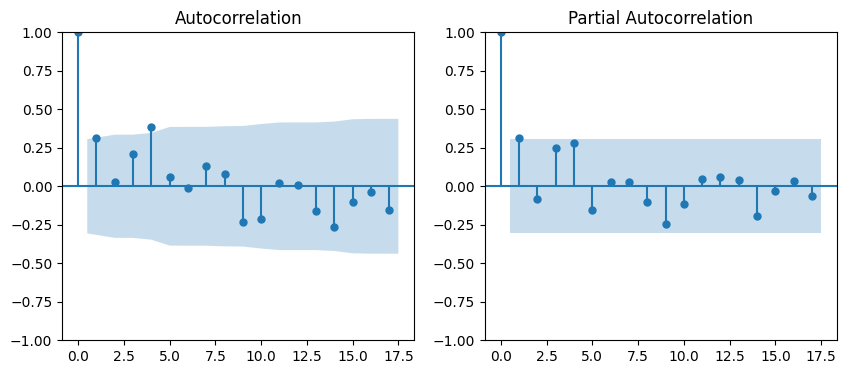

In [ ]:
#Dropping NaN Values for the difference of series
difference_series = series.diff().dropna()

# Plot ACF and PACF of differenced time series
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_acf(difference_series, ax=axes[0])
plot_pacf(difference_series, ax=axes[1])
plt.show()

In [ ]:
# On observing these plots we get p, q as 1,1 respectively, i.e. time series is predicted as stationary
p, d, q = 1, 1, 1
model = ARIMA(series, order=(p, d, q))
results = model.fit()
print(results.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.



                               SARIMAX Results                                
Dep. Variable:            Subscribers   No. Observations:                   42
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -672.993
Date:                Tue, 05 Nov 2024   AIC                           1351.986
Time:                        13:00:29   BIC                           1357.127
Sample:                    04-01-2013   HQIC                          1353.858
                         - 07-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.012     80.765      0.000       0.975       1.024
ma.L1         -0.9908      0.221     -4.476      0.000      -1.425      -0.557
sigma2      1.187e+13   1.57e-14   7.57e+26      0.0

In [ ]:
#Predicting further results
future_steps = 5
predictions = results.predict(len(series), len(series) + future_steps - 1)
predictions = predictions.astype(int)
print(predictions)

2023-10-01    243321458
2024-01-01    248251648
2024-04-01    253180570
2024-07-01    258108224
2024-10-01    263034611
Freq: QS-OCT, Name: predicted_mean, dtype: int64


In [ ]:
#Predicting the next five quarters
# Create a DataFrame with the original data and predictions
forecast = pd.DataFrame({'Original': series, 'Predictions': predictions})

# Plot the original data and predictions
fig = go.Figure()

fig.add_trace(go.Scatter(x=forecast.index, y=forecast['Predictions'],
                         mode='lines', name='Predictions'))

fig.add_trace(go.Scatter(x=forecast.index, y=forecast['Original'],
                         mode='lines', name='Original Data'))

fig.update_layout(title='Netflix Quarterly Subscription Predictions',
                  xaxis_title='Time Period',
                  yaxis_title='Subscribers',
                  legend=dict(x=0.1, y=0.9),
                  showlegend=True)

fig.show()

This is how time series can be predicted for the Netflix Quarterly subscription counts for upcoming quarters.

In [20]:
import pandas as pd

forecast_data = pd.DataFrame({
    "Time Period": pd.date_range(start="2023-01-01", periods=5, freq="Q"),
    "Subscribers": predictions # Add the 'Subscribers' column with the predictions
})

# The initial and final subscriber count in the forecasted period
initial_subscribers = forecast_data["Subscribers"].iloc[0]
final_subscribers = forecast_data["Subscribers"].iloc[-1]

# The percentage increase
percentage_increase = ((final_subscribers - initial_subscribers) / initial_subscribers) * 100

print(f"The percentage increase in subscribers over the forecasted five quarters is {percentage_increase:.2f}%")

The percentage increase in subscribers over the forecasted five quarters is 8.10%


<ipython-input-20-8e435ec13329>:4: FutureWarning:

'Q' is deprecated and will be removed in a future version, please use 'QE' instead.



In [19]:
import pandas as pd

forecast_index = pd.date_range(start=series.index[-1] + pd.DateOffset(months=3), periods=len(predictions), freq="Q")

forecast_data = pd.DataFrame({
    "Time Period": forecast_index,
    "Subscribers": predictions
})

forecast_data = pd.concat([series.to_frame(), forecast_data], axis=0)
forecast_data.set_index("Time Period", inplace=True)

# The initial and final subscriber count in the entire dataset (original + forecast)
initial_subscribers = forecast_data["Subscribers"].iloc[0]
final_subscribers = forecast_data["Subscribers"].iloc[-1]

# The percentage increase
percentage_increase = ((final_subscribers - initial_subscribers) / initial_subscribers) * 100

print(f"The percentage increase in subscribers over the entire period is {percentage_increase:.2f}%")

The percentage increase in subscribers over the entire period is 668.21%


<ipython-input-19-fc3309e9fcf2>:3: FutureWarning:

'Q' is deprecated and will be removed in a future version, please use 'QE' instead.

